# Imports

In [1]:
import sys
sys.path.append("../Face_detection")

import glob
import zipfile
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from sklearn.metrics import f1_score
from tensorflow.keras.applications import MobileNetV2, MobileNet, EfficientNetB0, ResNet50, InceptionV3, VGG16
from tensorflow.keras import regularizers, initializers, Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, SpatialDropout2D, GlobalMaxPooling2D, AveragePooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-06-25 07:35:12.496518: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 07:35:12.536607: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-25 07:35:12.536645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-25 07:35:12.537569: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-25 07:35:12.544898: I tensorflow/core/platform/cpu_feature_guar

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

tf.config.set_visible_devices(gpus[0], 'GPU')  # Select GPU:1

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Hyperparameter for the model

In [14]:
batch_size = 24
target_size = (224, 224)
learning_rate = 0.0001
kernel_s = (3, 3)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Data Augmentation

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

train_gen=train_datagen.flow_from_directory(
    'Train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_gen=valid_datagen.flow_from_directory(
    'Validate',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_gen=valid_datagen.flow_from_directory(
    'Test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 7825 images belonging to 5 classes.
Found 489 images belonging to 5 classes.
Found 1467 images belonging to 5 classes.


# Plotting a batch of training data

Class labels: ['Asian', 'Black', 'Indian', 'Others', 'White']


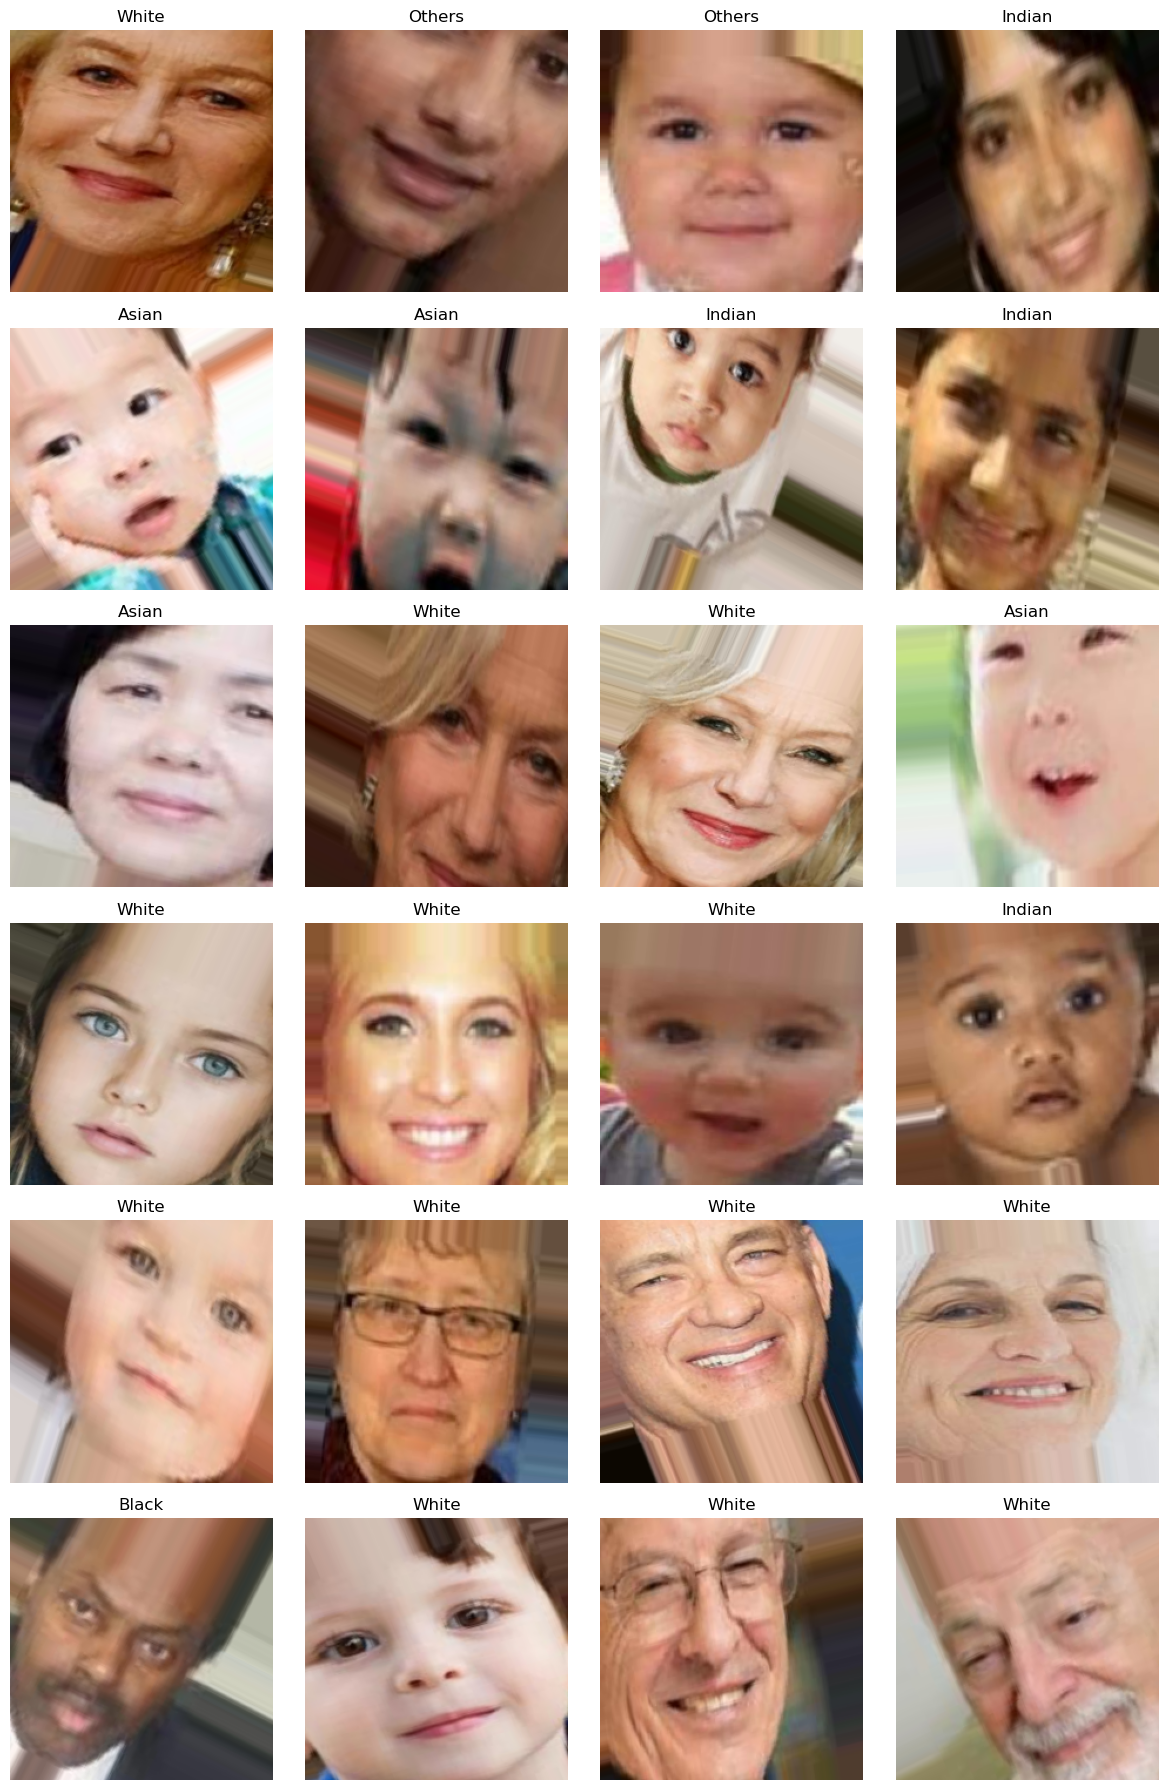

In [16]:
x_batch, y_batch = next(train_gen)
num_images = x_batch.shape[0]
cols = 4
rows = (num_images + cols - 1) // cols

class_labels = list(train_gen.class_indices.keys())
print(f"Class labels: {class_labels}")

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    ax.imshow(x_batch[i])
    
    class_index = y_batch[i].argmax()
    label = class_labels[class_index]
    
    ax.set_title(label)
    ax.axis('off')

for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Set up and configure a model for training

In [26]:
# These two models are also not bad
# base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # Is correct on the test data, but not on my own
# base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # Works for my images, but isn't correct on the test data

# https://arxiv.org/abs/1409.4842 - Paper of the Inception architecture
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = False 

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.summary()

327
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_4 (Flatten)         (None, 51200)             0         
                                                                 
 dense_8 (Dense)             (None, 1024)              52429824  
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 74237733 (283.19 MB)
Trainable params: 59608261 (227.39 MB)
Non-trainable params: 14629472 (55.81 MB)
_________________________________________________________________


# Compile the model and start the training

In [30]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(
    train_gen,
    batch_size=batch_size,
    epochs=20,
    validation_data=valid_gen,
    steps_per_epoch=len(train_gen),
    callbacks=[early_stopping]
)

Epoch 1/20
327/327 [==============================] - 77s 215ms/step - loss: 0.9943 - acc: 0.6451 - val_loss: 0.7748 - val_acc: 0.7178
Epoch 2/20
327/327 [==============================] - 70s 214ms/step - loss: 0.9192 - acc: 0.6726 - val_loss: 0.7656 - val_acc: 0.7382
Epoch 3/20
327/327 [==============================] - 70s 214ms/step - loss: 0.8642 - acc: 0.6923 - val_loss: 0.7094 - val_acc: 0.7444
Epoch 4/20
327/327 [==============================] - 70s 214ms/step - loss: 0.8128 - acc: 0.7077 - val_loss: 0.7176 - val_acc: 0.7607
Epoch 5/20
327/327 [==============================] - 70s 213ms/step - loss: 0.7923 - acc: 0.7195 - val_loss: 0.6210 - val_acc: 0.7710
Epoch 6/20
327/327 [==============================] - 70s 213ms/step - loss: 0.7834 - acc: 0.7199 - val_loss: 0.7224 - val_acc: 0.7382
Epoch 7/20
327/327 [==============================] - 70s 213ms/step - loss: 0.7833 - acc: 0.7249 - val_loss: 0.7135 - val_acc: 0.7464
Epoch 8/20
327/327 [==============================] - 7

# Plot the results of the training

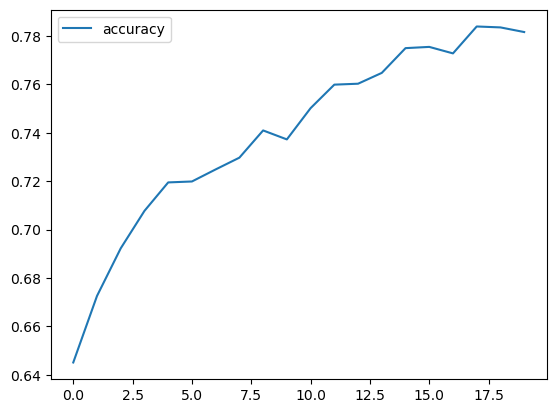

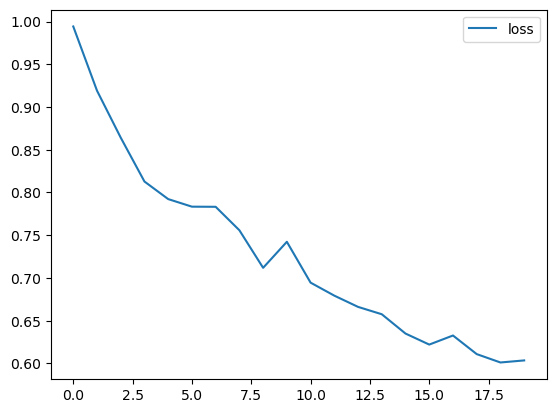

In [31]:
plt.plot(history.history['acc'], label='accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.legend()

# Test the model on the test data

1/1 [==============================] - 1s 1s/step


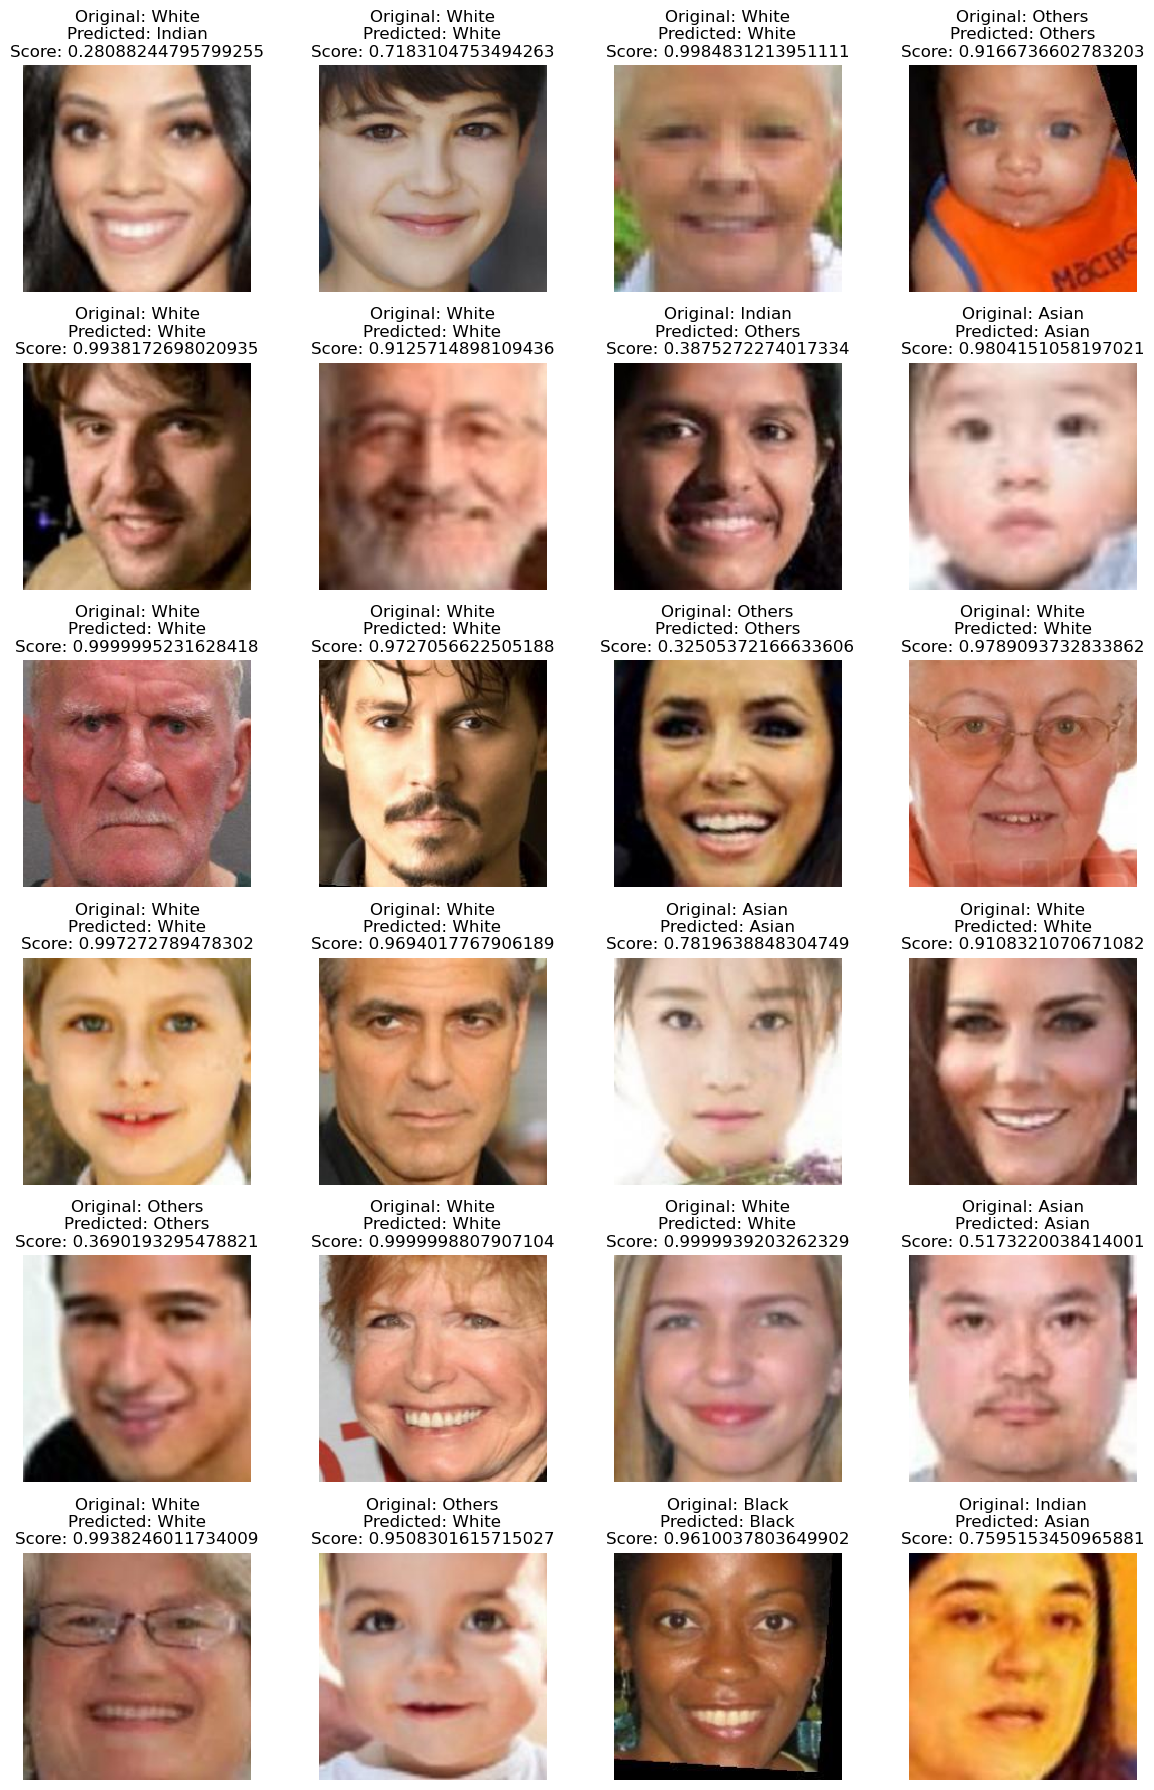

In [32]:
x_batch, y_batch = next(test_gen)
predictions = model.predict(x_batch)

predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_batch, axis=1)

num_images = x_batch.shape[0]
cols = 4
rows = (num_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    ax.imshow(x_batch[i])

    true_label = class_labels[true_labels[i]]
    predicted_label = class_labels[predicted_labels[i]]
    prediction_score = predictions[i][predicted_labels[i]]

    ax.set_title(f"Original: {true_label}\nPredicted: {predicted_label}\nScore: {prediction_score}")
    ax.axis('off')

for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Test the model on my own data

1/1 [==============================] - 0s 40ms/step


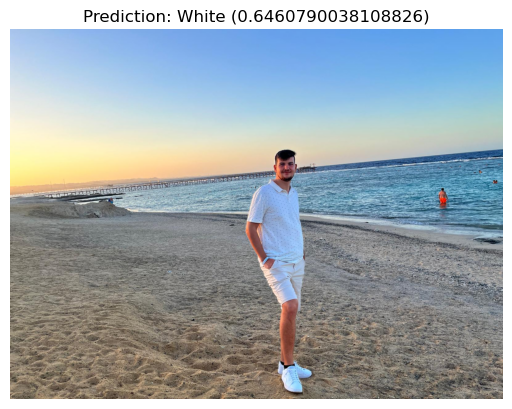

1/1 [==============================] - 0s 43ms/step


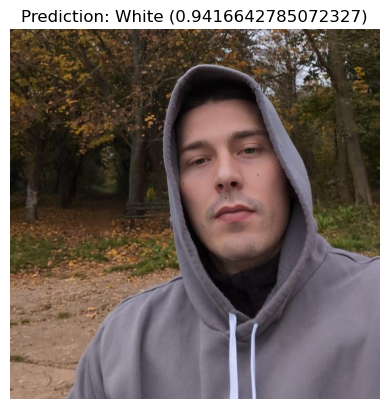

1/1 [==============================] - 0s 35ms/step


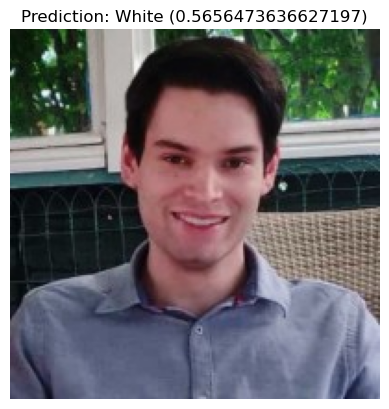

1/1 [==============================] - 0s 36ms/step


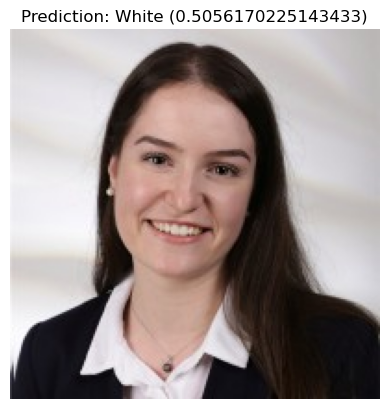

1/1 [==============================] - 0s 38ms/step


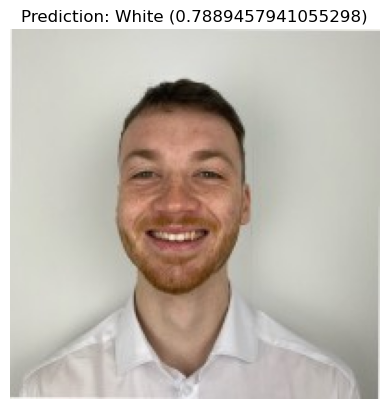

1/1 [==============================] - 0s 38ms/step


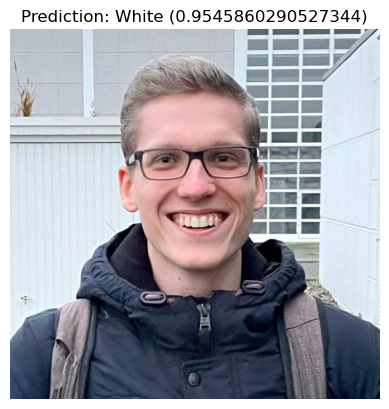

In [33]:
def edit_image(image_path: str) -> np.array: 
    img = load_img(image_path, target_size=target_size)

    img_array = img_to_array(img)
    img_array = img_array / 255.0 

    img_array = np.expand_dims(img_array, axis=0)

    return img_array

images = glob.glob('../Images/*.jpg')

for i, image in enumerate(images):
        img_array = edit_image(image)

        prediction = model.predict(img_array)

        predicted_label_index = np.argmax(prediction, axis=1)[0]
        predicted_label = class_labels[predicted_label_index]
        confidence = prediction[0][predicted_label_index]

        plt.imshow(load_img(image))
        plt.title(f"Prediction: {predicted_label} ({confidence:})")
        plt.axis("off")
        plt.show()

# Evaluate the model ans save it to a file

In [35]:
model.evaluate(test_gen)
model.save("../Models/Nation_classification")

62/62 [==============================] - 2s 39ms/step - loss: 0.6914 - acc: 0.7635


# Test the model on detected and extracted faces

In [ ]:
print(f"Loading the model: Nation_classification")
model = load_model("../Models/Nation_classification")
print("Successfully loaded the model: Nation_classification")

predict_detected_faces(model=model, class_names=class_names, padding=0.2, image_directory="../Images/*.jpg")